# 第十八、十九、二十次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW18-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">6月10日23:59前</span>提交**

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
torch.manual_seed(0)
np.random.seed(0)

### 读取数据并划分数据集（勿更改代码）

In [19]:
def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

# 一、隐马尔可夫模型（2分）

### 1.1 准备数据（0.5分）

In [20]:
from hmmlearn import hmm
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [21]:
# 提取特征
def extract_features(data):
    features = []
    lengths = []
    for name in data:
        feature = [all_letters.index(char) for char in name]
        features.extend(feature)
        lengths.append(len(name))
    return np.array(features).reshape(-1, 1), lengths

X_train_features, X_train_lengths = extract_features(X_train)
X_test_features, X_test_lengths = extract_features(X_test)

### 1.2 使用HMM模型进行训练、预测（1分）

In [22]:
# 训练HMM模型
hmm_model = hmm.MultinomialHMM(n_components=n_tags, n_iter=100)
hmm_model.fit(X_train_features, X_train_lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=14, n_iter=100,
               n_trials=array([66, 57, 14, ..., 39,  1, 71]),
               random_state=RandomState(MT19937) at 0x1076F5F40)

In [23]:
# HMM预测
def hmm_predict(model, X, lengths):
    posteriors = model.predict(X, lengths)
    predictions = []
    index = 0
    for length in lengths:
        # 取每个序列的最后一个预测
        predictions.append(posteriors[index + length - 1])
        index += length
    return predictions
y_train_pred = hmm_predict(hmm_model, X_train_features, X_train_lengths)
y_test_pred = hmm_predict(hmm_model, X_test_features, X_test_lengths)

### 1.3 模型评估（0.5分）

In [24]:
# 评估函数
def evaluate(y_true, y_pred):
    correct = sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy

# HMM结果
print("HMM结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

HMM结果
train set accuracy: 0.0803
test set accuracy: 0.0813


## 二、RNN模型的应用（3分）

### 2.1 数据准备和预处理（0.5分）

### 字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [3]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)

In [4]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [5]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [6]:
#create a dataloader

def dataloader(batch_size, X_, y_):
    to_ret = []
    for i in range(batch_size):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, name_rep(name), nat_rep(lang)))

    return to_ret

### 2.2 RNN网络的搭建（1分）

In [8]:
# TODO(4分)
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [33]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2tag = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):
        lstm_out, hidden = self.lstm(input_.view(len(input_), 1, -1), hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(input_), -1))
        tag_scores = self.softmax(tag_space)
        return tag_scores, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

### 2.3 模型的训练（1分）

In [9]:
# function to train the data

def train_step(net, opt, criterion, batch_size):
    
    opt.zero_grad()
    total_loss = 0
    data_ = dataloader(batch_size, X_train, y_train)
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/batch_size

In [10]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):

    # TODO(2分)
    criterion = None 
    opt = None
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    loss_arr = np.zeros(steps)

    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")

In [11]:
def train_rnn(model, cnn_model, lr, steps, batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for step in range(steps):
        # 获取随机批次数据
        batch = dataloader(batch_size, X_train, y_train)
        names, langs, name_reps, lang_reps = zip(*batch)
        name_reps = torch.stack(name_reps)
        lang_reps = torch.stack(lang_reps).squeeze()

        # 使用CNN提取特征
        features = cnn_model(name_reps)

        # RNN模型训练
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, lang_reps)
        loss.backward()
        optimizer.step()

        if (step+1) % 10 == 0:
            print(f"Step [{step+1}/{steps}], Loss: {loss.item():.4f}")

/Users/xiongjiangkai/.virtualenvs/.Data_science/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iteration number: 5 Loss: 2.4736
Iteration number: 10 Loss: 2.1272
Iteration number: 15 Loss: 1.9901
Iteration number: 20 Loss: 1.9632
Iteration number: 25 Loss: 1.7942
Iteration number: 30 Loss: 1.6796
Iteration number: 35 Loss: 1.543
Iteration number: 40 Loss: 1.4826
Iteration number: 45 Loss: 1.509
Iteration number: 50 Loss: 1.4076
Iteration number: 55 Loss: 1.4225
Iteration number: 60 Loss: 1.3462
Iteration number: 65 Loss: 1.385
Iteration number: 70 Loss: 1.2047
Iteration number: 75 Loss: 1.2023
Iteration number: 80 Loss: 1.1721
Iteration number: 85 Loss: 1.0912
Iteration number: 90 Loss: 1.3168
Iteration number: 95 Loss: 1.2583
Iteration number: 100 Loss: 1.2342


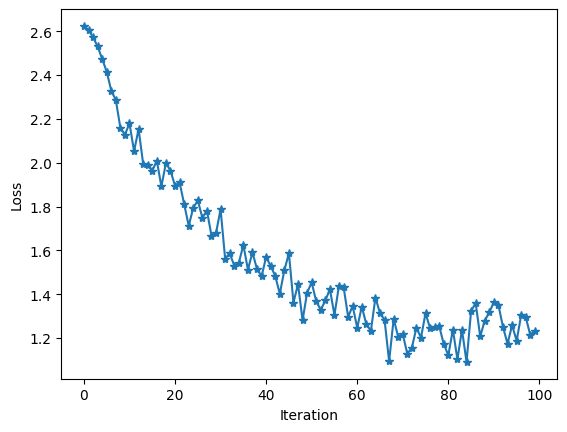

In [12]:
# RNN训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.0005, steps = 100, batch_size = 256)

Iteration number: 5 Loss: 2.5384
Iteration number: 10 Loss: 2.3473
Iteration number: 15 Loss: 2.2672
Iteration number: 20 Loss: 2.256
Iteration number: 25 Loss: 2.2335
Iteration number: 30 Loss: 2.1505
Iteration number: 35 Loss: 2.2421
Iteration number: 40 Loss: 2.089
Iteration number: 45 Loss: 2.2204
Iteration number: 50 Loss: 2.1152
Iteration number: 55 Loss: 2.112
Iteration number: 60 Loss: 2.101
Iteration number: 65 Loss: 1.949
Iteration number: 70 Loss: 2.0707
Iteration number: 75 Loss: 1.9283
Iteration number: 80 Loss: 1.9508
Iteration number: 85 Loss: 1.7663
Iteration number: 90 Loss: 1.6651
Iteration number: 95 Loss: 1.6802
Iteration number: 100 Loss: 1.6308
Iteration number: 105 Loss: 1.5946
Iteration number: 110 Loss: 1.6142
Iteration number: 115 Loss: 1.5454
Iteration number: 120 Loss: 1.4061
Iteration number: 125 Loss: 1.4989
Iteration number: 130 Loss: 1.4832
Iteration number: 135 Loss: 1.3497
Iteration number: 140 Loss: 1.4423
Iteration number: 145 Loss: 1.2765
Iteration 

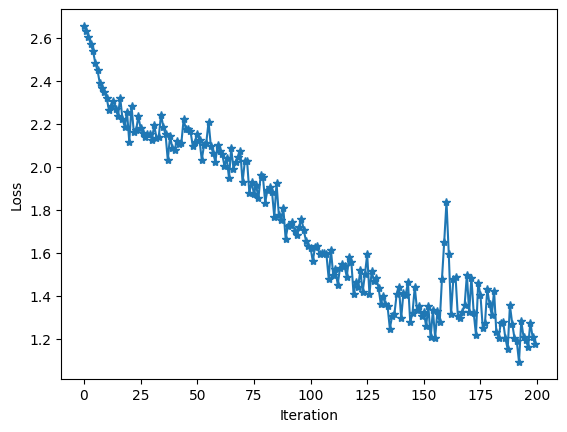

In [36]:
# LSTM训练
n_hidden = 128
lstm_net = LSTM_net(n_letters, n_hidden, n_tags)
train(lstm_net, lr = 0.0005, steps = 200, batch_size = 256)

### 2.4 模型的评估（0.5分）

In [13]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [14]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [15]:
#create a function to evaluate model

def eval_train(net):
     correct = 0
     for i in range(len(X_train)):
        name,lang = X_train[i],y_train[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_train)

     return accuracy

In [16]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.5834
test set accuracy:0.5705


In [37]:
print("LSTM结果")
print("train set accuracy:"+str(round(eval_train(lstm_net),4)))
print("test set accuracy:"+str(round(eval_test(lstm_net),4)))

LSTM结果
train set accuracy:0.5998
test set accuracy:0.5945


## 三、预训练模型的使用（3分）

### 3.1 数据准备和预处理，模型的导入（0.5分）

In [25]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

### 3.2 使用BERT进行特征提取（1分）

In [26]:
# 提取BERT特征
def extract_bert_features(data):
    features = []
    for name in data:
        inputs = tokenizer(name, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        # 取最后一层的CLS token的输出作为特征
        cls_output = outputs.last_hidden_state[:, 0, :].numpy()
        features.append(cls_output)
    return np.vstack(features)

# 提取训练集和测试集的特征
X_train_features = extract_bert_features(X_train)
X_test_features = extract_bert_features(X_test)

In [27]:
# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 3.3 使用一个分类器对提取好的特征进行分类（1分）

In [28]:
# 使用逻辑回归进行分类
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_features, y_train_encoded)

LogisticRegression(max_iter=1000)

In [29]:
# 预测
y_train_pred = clf.predict(X_train_features)
y_test_pred = clf.predict(X_test_features)

### 3.4 评估结果（0.5分）

In [30]:
# 评估函数
def evaluate(y_true, y_pred):
    correct = sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy

# BERT结果
print("BERT结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

BERT结果
train set accuracy: 0.9069
test set accuracy: 0.7909


In [38]:
# 将tokenizer输出的字符进行one-hot编码
def name_rep(name):
    tokens = tokenizer.tokenize(name)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    rep = torch.zeros(len(token_ids), 1, tokenizer.vocab_size)
    for i, token_id in enumerate(token_ids):
        rep[i][0][token_id] = 1
    return rep

In [39]:
# 训练RNN
def train_step(net, opt, criterion, batch_size):
    opt.zero_grad()
    total_loss = 0
    for _ in range(batch_size):
        index_ = np.random.randint(len(X_train))
        name, language = X_train[index_], y_train[index_]
        name_ohe, lang_rep = name_rep(name), torch.tensor([le.transform([language])[0]], dtype=torch.long)

        hidden = net.init_hidden()
        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
        
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        total_loss += loss.item()
        
    opt.step()
    return total_loss / batch_size

In [40]:
def train(net, lr=0.01, steps=100, batch_size=10, momentum=0.9, freq=5):
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    loss_arr = np.zeros(steps)
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i + 1) % freq == 0:
            print("Iteration number:", i + 1, 'Loss:', round(loss_arr[i], 4))
    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

Iteration number: 5 Loss: 2.561
Iteration number: 10 Loss: 2.3702
Iteration number: 15 Loss: 2.2765
Iteration number: 20 Loss: 2.1939
Iteration number: 25 Loss: 2.2222
Iteration number: 30 Loss: 2.1432
Iteration number: 35 Loss: 2.1271
Iteration number: 40 Loss: 2.1742
Iteration number: 45 Loss: 2.1761
Iteration number: 50 Loss: 2.0891
Iteration number: 55 Loss: 2.2147
Iteration number: 60 Loss: 2.1292
Iteration number: 65 Loss: 2.1258
Iteration number: 70 Loss: 2.1188
Iteration number: 75 Loss: 2.1509
Iteration number: 80 Loss: 2.0252
Iteration number: 85 Loss: 2.1188
Iteration number: 90 Loss: 2.0086
Iteration number: 95 Loss: 2.0561
Iteration number: 100 Loss: 2.0572


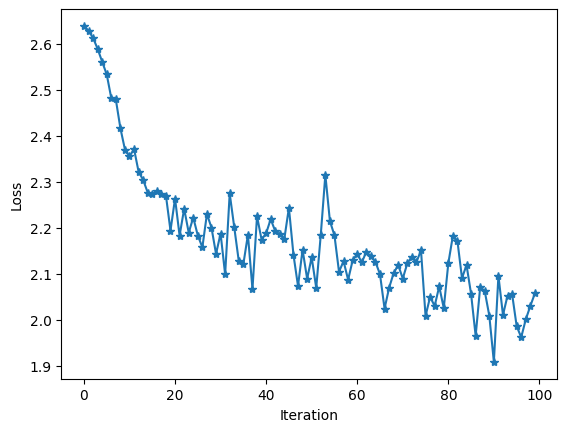

In [41]:
# 训练RNN
n_hidden = 128
rnn_net = RNN_net(tokenizer.vocab_size, n_hidden, len(tags))
train(rnn_net, lr=0.0005, steps=100, batch_size=256)

In [42]:
# 评估RNN模型
def eval_model(net, X, y):
    correct = 0
    for i in range(len(X)):
        name, lang = X[i], y[i]
        name_ohe = name_rep(name)
        lang_rep = torch.tensor([le.transform([lang])[0]], dtype=torch.long)
        output = infer(net, name)
        val, indices = output.topk(1)
        if indices == lang_rep:
            correct += 1
    accuracy = correct / len(X)
    return accuracy

# RNN结果
print("RNN结果")
print("train set accuracy:", round(eval_model(rnn_net, X_train, y_train), 4))
print("test set accuracy:", round(eval_model(rnn_net, X_test, y_test), 4))

RNN结果
train set accuracy: 0.3382
test set accuracy: 0.3576


## 四、三种模型的总结与分析（1分）

请简述这次作业使用的数据集在三种模型下的表现产生显著差异的原因，并且给出能够提高HMM表现的数据加强方式。

## 附加题：期末笔试题目的参考

### 附加题 马尔可夫模型的原理理解（1分）

(1) 阅读以下题目，补全solve函数，并且将结果提交到codeforces平台上，将代码运行结果截图（包含用户名、AC的结果、运行时间等信息）（0.5分）

提交的网址：https://codeforces.com/problemset/problem/1025/G

运行结果截图

![](./3.png)

![](./1.png)

In [ ]:
def solve(n,lis):
    print((2**(n-1)-1-sum([2**lis.count(x)-1 for x in set(lis)-set(['-1'])]))%(10**9+7))

n=int(input())
lis=input().split()
solve(n,lis)

(2) 对以上代码的正确性给出证明（0.5分）

方法一：
![](./4.png)

方法2:
![](./5.png)